# Predicting Price with Size

### Neste projeto, estou trabalhando para um cliente que deseja criar um modelo que possa prever o preço de apartamentos na cidade de Buenos Aires — com foco em apartamentos que custam menos de US$ 400.000.

### Preparação dos dados

Importação das bibliotecas

In [2]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

Importação dos dados

In [9]:
df_inicial = pd.read_csv('/content/buenos-aires-real-estate-1.csv')
print("df_inicial shape:", df_inicial.shape)
df_inicial.head()

df_inicial shape: (8606, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
1,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,NaN,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,http://ramos-mejia.properati.com.ar/s7pd_venta...
2,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Cast...,"-34.6497002,-58.658073",410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,http://castelar-moron.properati.com.ar/11vgn_v...
3,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,"-34.5957086,-58.5669503",180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,http://tres-de-febrero.properati.com.ar/7f7u_v...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...


Explicação da função `wrangle()`

A função `wrangle(filepath)` tem como objetivo importar e filtrar os dados de imóveis contidos em um arquivo CSV. Ela realiza os seguintes passos:

1. **Importação dos dados**  
   Lê o arquivo CSV localizado no caminho informado e carrega os dados em um DataFrame.

2. **Filtragem por localização**  
   Mantém apenas os imóveis localizados na região de **"Capital Federal"**.

3. **Filtragem por tipo de imóvel**  
   Mantém apenas os imóveis do tipo **"apartment"** (apartamentos).

4. **Filtragem por preço**  
   Exclui os imóveis com preço acima de **400 mil dólares**.

5. **Filtragem por área útil**  
   Remove os imóveis com área útil fora do intervalo entre o **10º e o 90º percentis** da variável `surface_covered_in_m2`, eliminando valores extremos (outliers).

6. **Retorno do DataFrame limpo**  
   A função retorna apenas os imóveis que atendem a todos os critérios anteriores, prontos para análise ou modelagem.


In [3]:
def wrangle(filepath):
    #Import CVS
    df = pd.read_csv(filepath)

    # Subset to properties in 'Capital Federal'
    mask_ba = df['place_with_parent_names'].str.contains('Capital Federal')
    # Subset to 'apartments'
    mask_apt = df['property_type'] == 'apartment'
    # Subset to 'Price' < 400_000
    mask_price = df['price_aprox_usd'] < 400_000

    df = df[mask_ba & mask_apt & mask_price]

    # Subset to 'surface_covered_in_m2'
    low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_area = df['surface_covered_in_m2'].between(low, high)

    df = df[mask_area]

    return df

In [5]:
df = wrangle('/content/buenos-aires-real-estate-1.csv')
print("df shape:", df.shape)
df.head()

df shape: (1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


### Exploração

Explorando a relação entre tamanho e preço do apartamento.

Gráfico de dispersão que mostra o preço ("preço_aprox_usd") versus a área ("superfície_coberta_em_m²") em nosso conjunto de dados.

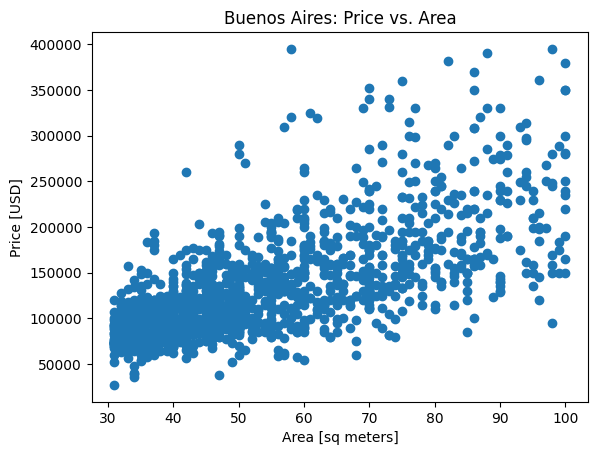

In [11]:
plt.scatter(x=df['surface_covered_in_m2'], y=df['price_aprox_usd'])
plt.xlabel('Area [sq meters]')
plt.ylabel('Price [USD]')
plt.title('Buenos Aires: Price vs. Area');

Este gráfico sugere que há uma correlação positiva moderada entre o preço do apartamento e o tamanho. Isso significa que, se o que queremos prever é o preço, o tamanho será um bom recurso a ser incluído.

## Split

Uma parte fundamental em qualquer projeto de construção de modelo é separar o seu alvo (o que você deseja prever) das suas características (as informações que o seu modelo usará para fazer suas previsões). Para este projeto, usaremos apenas uma característica: o tamanho do apartamento.

Criando a matriz de características chamada X_train, que sera usada para treinar o modelo. Ela contém apenas uma característica: ["surface_covered_in_m2"].

In [12]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(1343, 1)

Agora que temos os recursos, o próximo passo é criar um alvo.

Criando o vetor-alvo chamado y_train, que sera usado para treinar o modelo. O alvo deve ser "price_aprox_usd".

In [13]:
target = "price_aprox_usd"
y_train = df[target]
y_train.shape

(1343,)